# Image Classification Using CNN

In [1]:
#importing
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

## Importing data & preprocessing.

Preprocessing step is for resizing and normalizing images, becuase the images we got has already been augmented.

In [13]:
from tqdm import tqdm

#define function to get the data
def get_data(folder):
    X = [] #X  contains all the images
    y = [] #y contains wbcTypes (neutrophil, eosinophil, monocyte, lymphocyte)

    for wbcType in os.listdir(folder):
        if not wbcType.startswith('.'):
            if wbcType in ['NEUTROPHIL']:
                label = 0 #neutrophil
            elif wbcType in ['EOSINOPHIL']:
                label = 1 #eosinophil
            elif wbcType in ['MONOCYTE']:
                label = 2  #monocyte
            elif wbcType in ['LYMPHOCYTE']:
                label = 3 #lymphocyte         

            #access image
            for filename in tqdm(os.listdir(folder + wbcType)):
                img_file = cv2.imread(folder + wbcType + '/' + filename)
                
                #resize to save memory
                img_file = cv2.resize(img_file, (160,120))
                
                #normalize images
                img_file = cv2.normalize(img_file, None, 0, 255, cv2.NORM_MINMAX)
                #img as array
                if img_file is not None:
                    img_arr = np.asarray(img_file)

                    #add to list
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [12]:
#get the data
X_train, y_train = get_data('dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test = get_data('dataset2-master/dataset2-master/images/TEST/')

100%|██████████| 624/624 [00:00<00:00, 1247.86it/s]


In [14]:
from keras.utils.np_utils import to_categorical

#encode  to hot vector, just like one host encoder
y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)

In [15]:
#print all the shapes
print('X_train shape = ',X_train.shape)
print('X_test shape = ',X_test.shape)
print('y_train shape = ',y_train.shape)
print('y_test shape = ',y_testHot.shape)

X_train shape =  (9957, 120, 160, 3)
X_test shape =  (2487, 120, 160, 3)
y_train shape =  (9957,)
y_test shape =  (2487, 4)


## Building the Model

In [2]:
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Input, Softmax
from keras.layers import Flatten

input_shape = (120,160,3)
#building a basic model of CNN
model = Sequential([
    #-----------------FEATURE EXTRACTION LAYER---------------
    
    Conv2D(16, kernel_size=(3, 3), activation='relu',
           #1st layer always has an input shape
           input_shape=input_shape),
    
    MaxPool2D(),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    #-----------------FEATURE EXTRACTION LAYER---------------
    
    
    #-----------------FCN LAYER---------------
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
    #-----------------FCN LAYER---------------
])

Using TensorFlow backend.


In [65]:
#summarying the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 118, 158, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 59, 79, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 57, 77, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 26, 36, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 18, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 14976)            

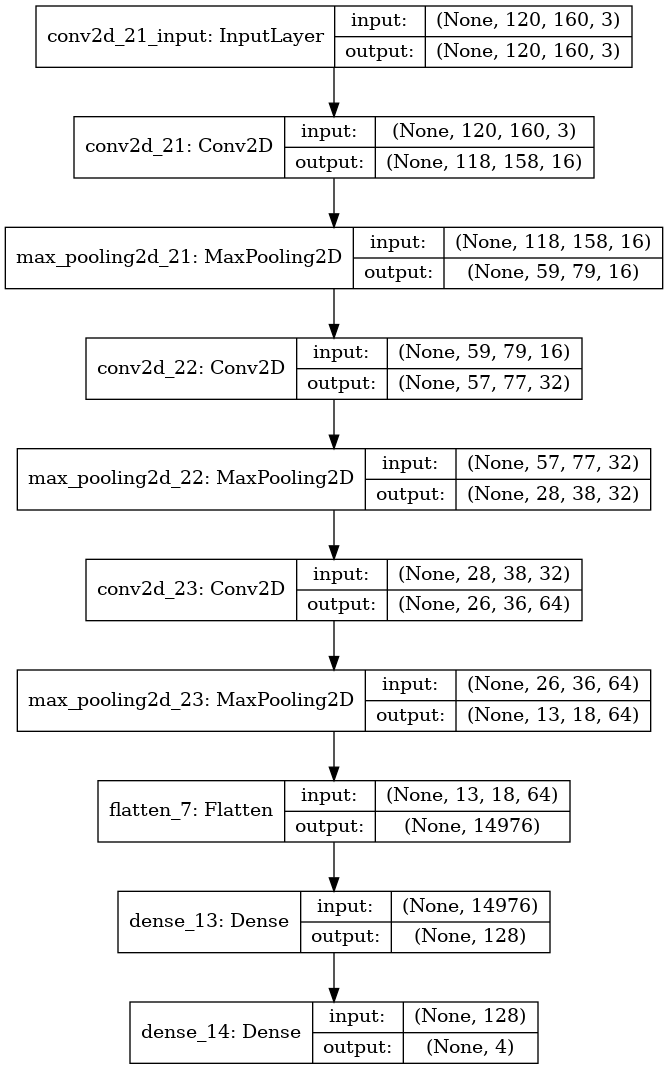

In [66]:
from keras.utils.vis_utils import plot_model

#plotting the model
plot_model(model, show_shapes=True, to_file="model.png")

In [67]:
#compiling model, because we have normalized all the image, (0 to 1), we use binary_crossentropy

model.compile(
    #because the data is divided into 4 classes, we use categorical_crossentropy
    loss='categorical_crossentropy',
    
    #very popular optimizer algorithm is Adam
    optimizer=Adam(),
    
    #to see training and validation accuracy for each training epoch
    metrics=['accuracy'])

In [68]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#training the model

#for every epoch, if the val_accuracy is better than the previous one, the network will be saved
checkpoint = ModelCheckpoint("Model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#if the val_accuracy doesn't increase for <patience> epochs, the training process will be stopped.
#use early for very large epochs
#early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='max') 

#callback
callbacks_list = [checkpoint] # [checkpoint, early] in the list to add early
,
#training the model
history = model.fit(
        #training data
        X_train,
    
        #label data
        y_trainHot,
                    
        #how many iteration the model has to learn
        epochs = 10,
    
        #the model will learn about data_train_size/batch_size iteration to finishes 1 epoch
        batch_size = 32,
        
        #validation data is to test the accuracy per epoch
        validation_data = (X_test,y_testHot),
    
        #callback is used to what to do after every epoch
        #for example, after every epoch we want to see if the val_accuracy is higher than before
        #if yes, then we save the model
        callbacks = callbacks_list)

Train on 9957 samples, validate on 2487 samples
Epoch 1/10
9957/9957 [==============================] - 9s 920us/step - loss: 5.7722 - accuracy: 0.6246 - val_loss: 5.7568 - val_accuracy: 0.6246

Epoch 00001: val_accuracy improved from -inf to 0.62465, saving model to newModel.h5
Epoch 2/10
9957/9957 [==============================] - 9s 905us/step - loss: 5.7720 - accuracy: 0.6247 - val_loss: 5.7568 - val_accuracy: 0.6246

Epoch 00002: val_accuracy did not improve from 0.62465
Epoch 3/10
9957/9957 [==============================] - 9s 905us/step - loss: 5.7720 - accuracy: 0.6247 - val_loss: 5.7568 - val_accuracy: 0.6246

Epoch 00003: val_accuracy did not improve from 0.62465
Epoch 4/10
9957/9957 [==============================] - 9s 906us/step - loss: 5.7720 - accuracy: 0.6247 - val_loss: 5.7568 - val_accuracy: 0.6246

Epoch 00004: val_accuracy did not improve from 0.62465
Epoch 5/10
9957/9957 [==============================] - 9s 905us/step - loss: 5.7720 - accuracy: 0.6247 - val_loss

## Evaluating the Model

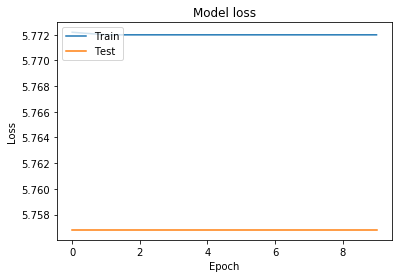

In [69]:
#plotting the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

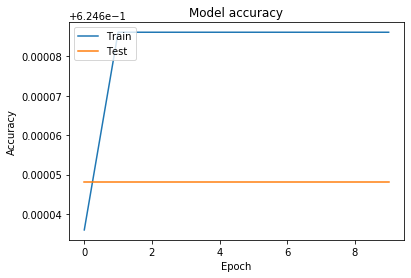

In [70]:
#plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [71]:
from keras.models import load_model

#getting the model with highest val_accuracy from checkpoint
model = load_model('Model.h5')

In [72]:
# Evaluate the model
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_testHot, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
2487/2487 [==============================] - 1s 332us/step
test loss, test acc: [5.756806063182296, 0.6246481537818909]


In [73]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred=model.predict(X_test)

#confusion matrix
print(confusion_matrix(y_testHot.argmax(axis=1), y_pred.argmax(axis=1)))
print('\n\n')

#classification report
print(classification_report(y_testHot.argmax(axis=1), y_pred.argmax(axis=1)))

[[  0   0   0 624]
 [  0   0   0 623]
 [  0   0   0 620]
 [  0   0   0 620]]



              precision    recall  f1-score   support

           0       0.00      0.00      0.00       624
           1       0.00      0.00      0.00       623
           2       0.00      0.00      0.00       620
           3       0.25      1.00      0.40       620

    accuracy                           0.25      2487
   macro avg       0.06      0.25      0.10      2487
weighted avg       0.06      0.25      0.10      2487



/home/bet/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the confusion matrix and classification report, it is very obvious that the model is very weak

# Reference

<b>Blog</b><br><br>

Importing data to List<br>
https://www.kaggle.com/paultimothymooney/identify-blood-cell-subtypes-from-images<br>

Pengenalan Deep Learning Part 7 : Convolutional Neural Network (CNN)<br>
https://medium.com/@samuelsena/pengenalan-deep-learning-part-7-convolutional-neural-network-cnn-b003b477dc94<br>

<b>Documentation</b><br><br>

The Sequential class<br>
https://keras.io/api/models/sequential/<br>

Optimizers<br>
https://keras.io/optimizers/<br>

Metrics<br>
https://keras.io/api/metrics/<br>

sklearn.metrics.confusion_matrix<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html<br>

sklearn.metrics.classification_report<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html